## Understanding of Image Segmentation

Suppose you want to know the shape of the object in an image, which pixel belongs to which object, etc, you need to assign a class to each pixel of the image - this task is known as segmentation.

A segmented model returns much more detailed information about the image. Some applications of image segmentation are in medical imaging, self-driving cars and satellite imaging, just to name a few.

This project uses the OXford-IIIT Pet Dataset(Parkhi et al, 2012). The dataset consists of images of 37 pet breeds, with 200 image per breed(~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:
    
    1. Class 1: Pixel belonging to the pet
    
    2. Class 2: Pixel bordering the pet.
    
    3. Class 3: None of the above/a surrounding pixel

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

C:\Users\ojare\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

### Download the Oxford-IIT Pets dataset

The dataset is available from TensorFlow Datasets. The segmentation masks are included in version 3+

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

The image color values are normalized to the [0, 1] range. Finally, as mentioned above the pixels in the segmentation are labelled either {1, 2, 3}. For the sake of convenienve, subtract 1 from the segmentation mask, resulting in labels that are: {0,1,2}. 

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [5]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (128, 128),
        method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

Use the dataset's training and test splits

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

Perform a simple augmentation by randomly-flipping an image.

In [8]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [10]:
# extra code to save the figures as high-res PNGs for the book
from pathlib import Path

IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    save_fig("sample_image_and_corresponding_mask")
    plt.show()

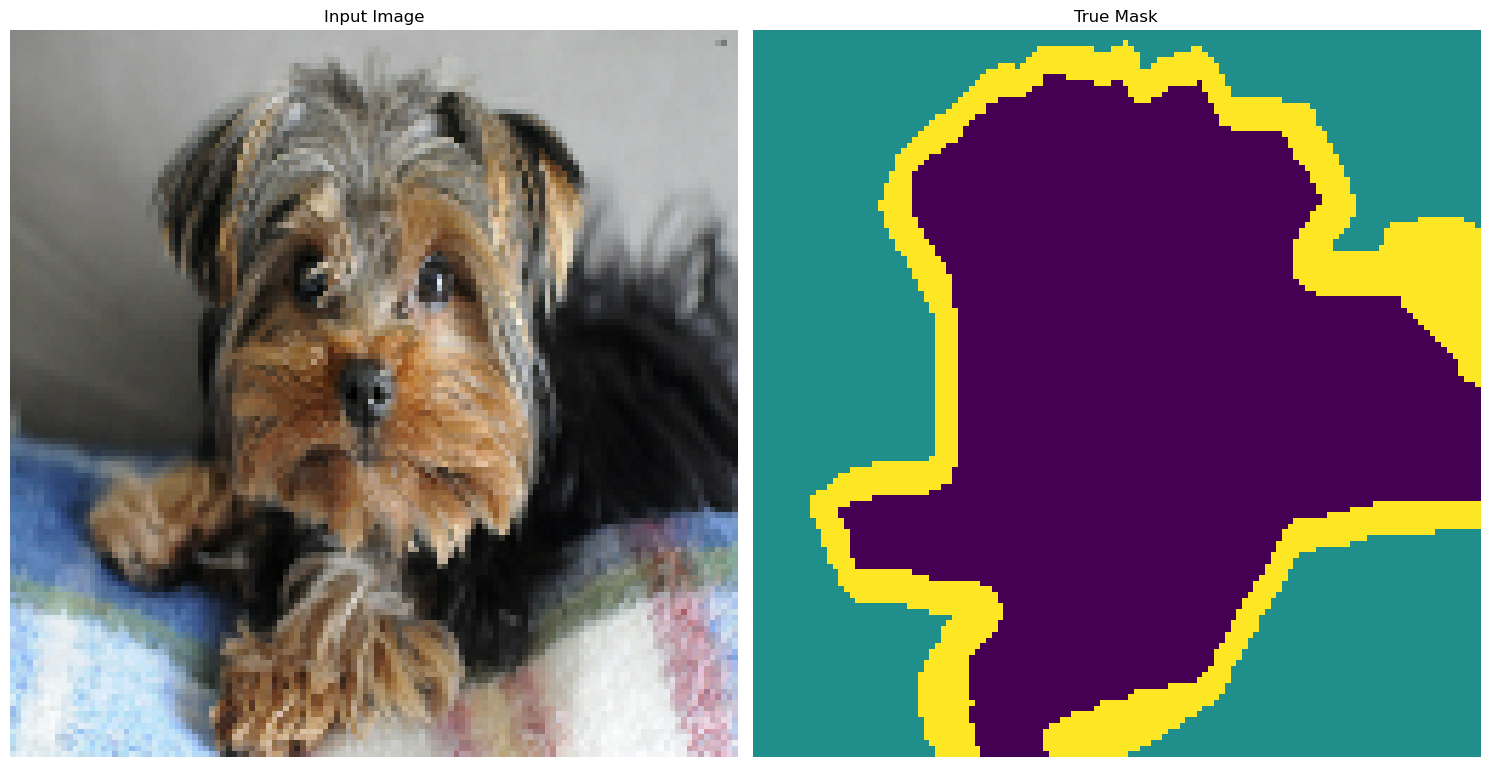

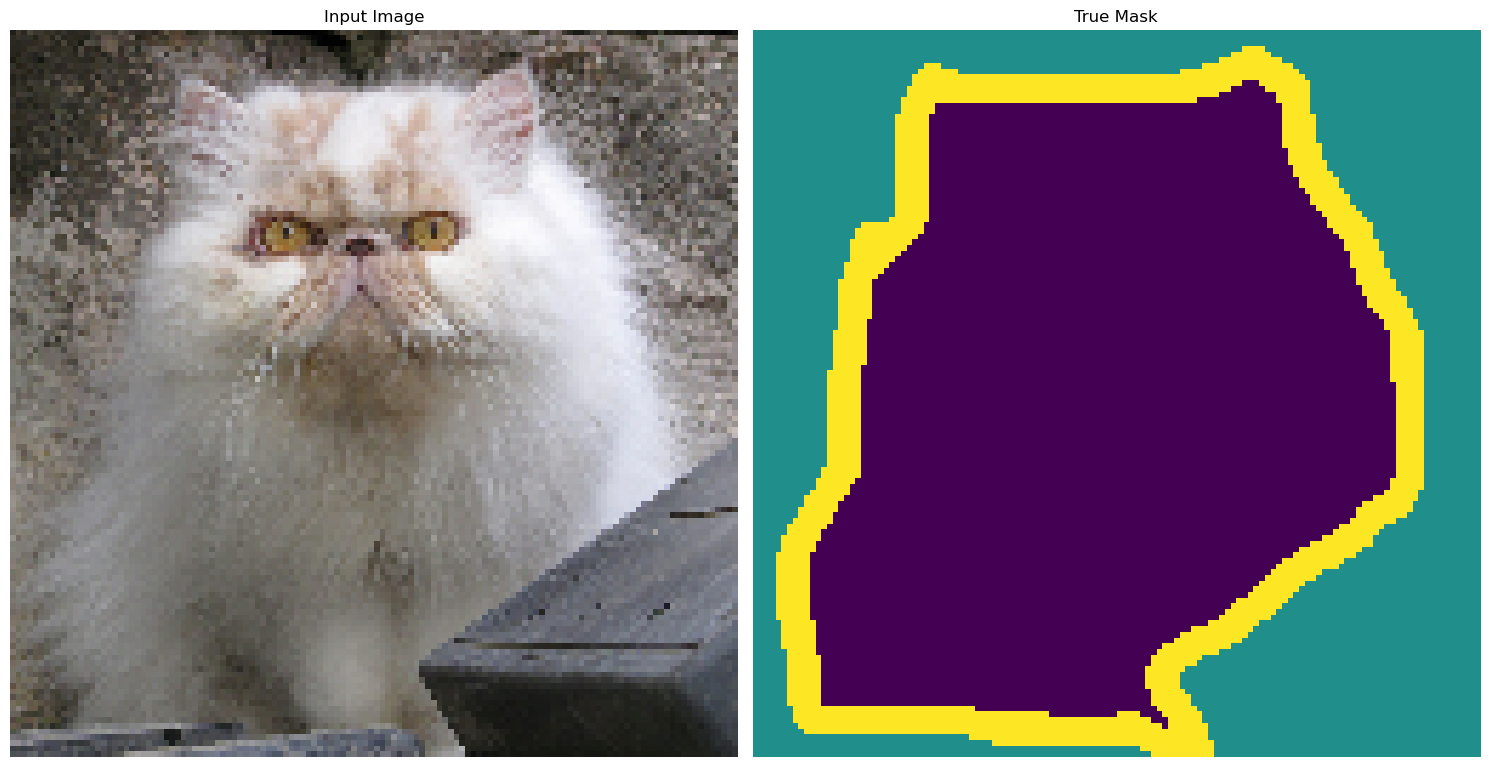

In [12]:
for images, masks in train_batches.take(2):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

#### Define the Model

The model being used here is a modified U-Net. A U-Net consists of an encoder(downsampler) and decoder(upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model-MobileNetV2-as the encoder. For the decoder, you will use the upsample block, which is already implemeted in the pix2pix example in the TensorFlow Examples repo.

The encoder is a pretrained MobileNetV2 model. You will use the model from tf.keras.applications. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu', # 64x64
    'block_3_expand_relu', # 32x32
    'block_6_expand_relu', # 16x16
    'block_13_expand_relu', # 8x8
    'block_16_project', # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# creatre the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

The decoder/upsample is simply a series of upsample blocks implemeted in TensorFLow Examples

In [14]:
up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3), # 32x32 -> 64x64
]

In [15]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        
    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same' #64x64 -> 128x128
    )
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number og output_channels. This will be one output per class

#### Train the model

Now all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the tf.keras.losses.CategoricalCrossentropy loss function with the from_logits argument set to True, since the labels are scalar integers instead of vector of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [16]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

#### Plot the resulting model architecture:

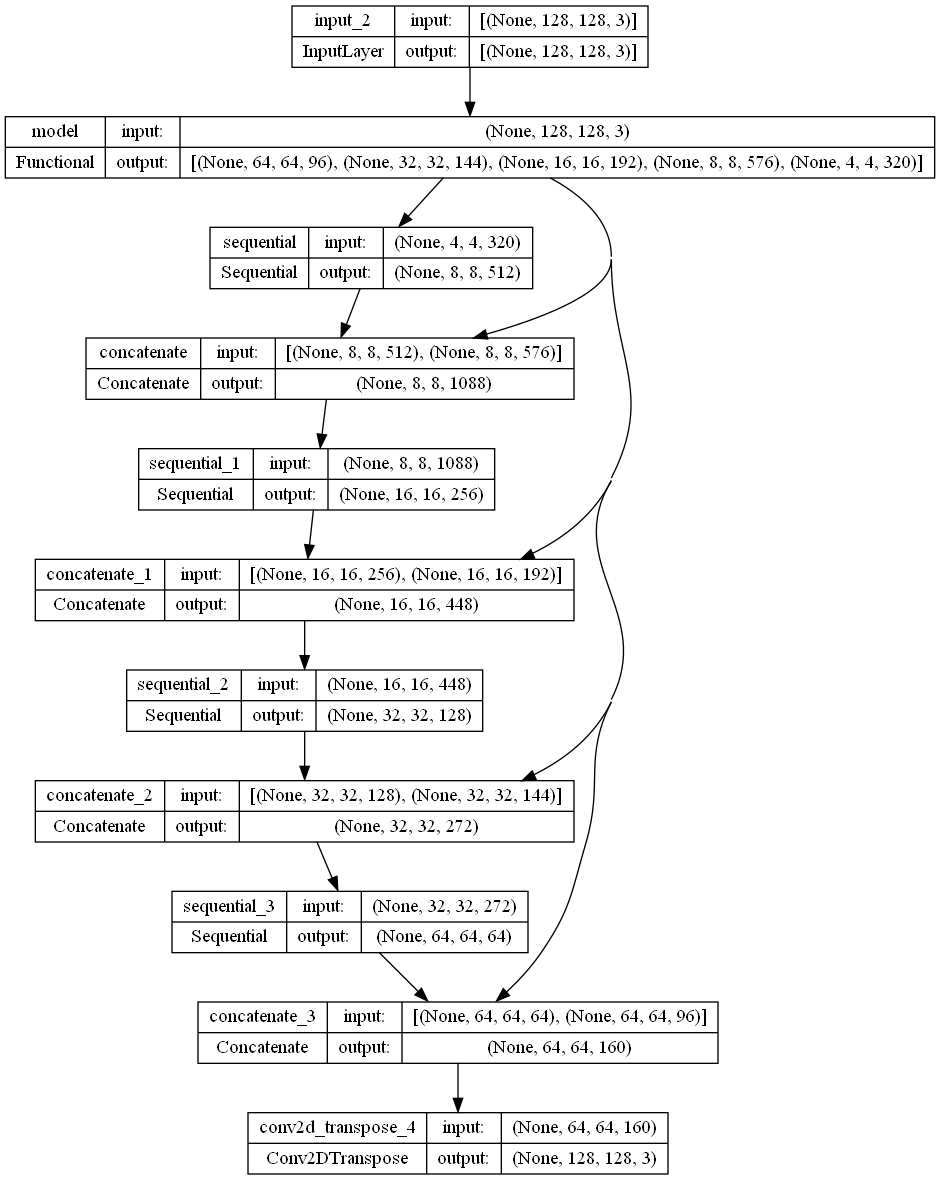

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [18]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 4s 4s/step


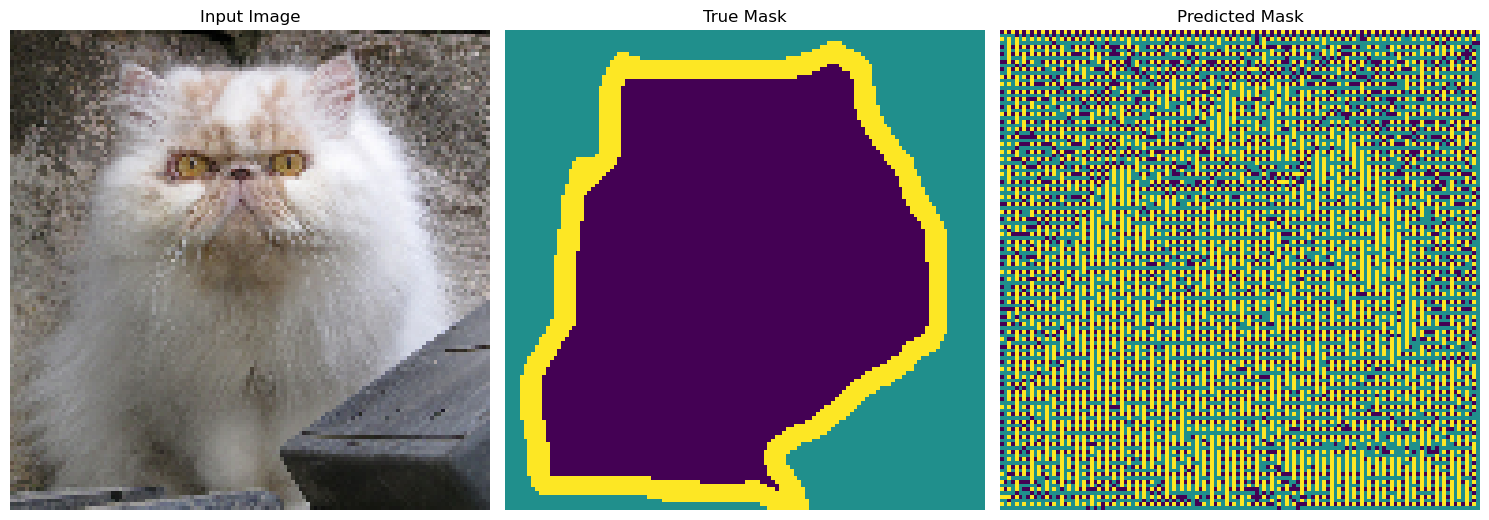

In [20]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print("\nSample Prediction after epoch {}\n". format(epoch+1))


1/1 [==============================] - 0s 130ms/step


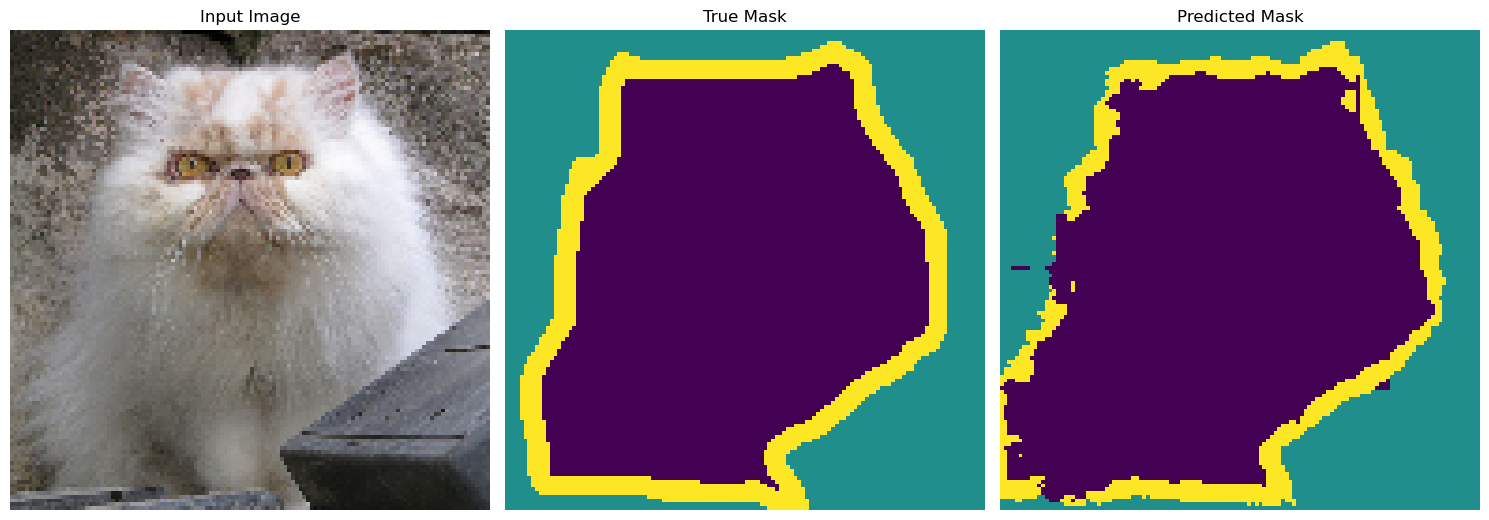


Sample Prediction after epoch 20

57/57 [==============================] - 511s 9s/step - loss: 0.1209 - accuracy: 0.9499 - val_loss: 0.3520 - val_accuracy: 0.8953


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits["test"].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                         steps_per_epoch=STEPS_PER_EPOCH,
                         validation_steps=VALIDATION_STEPS,
                         validation_data=test_batches,
                         callbacks=[DisplayCallback()])

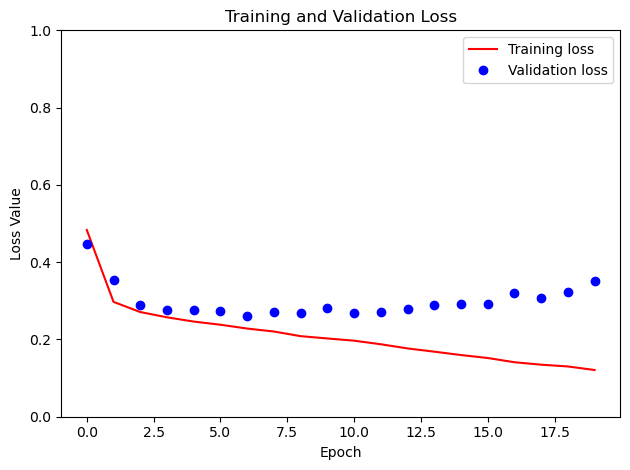

In [24]:
loss = model_history.history["loss"]
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label="Training loss")
plt.plot(model_history.epoch, val_loss, 'bo', label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0, 1])
plt.legend()
save_fig("training_and_validation_loss")
plt.show()

### Make Predictions

In the interest of saving time, the number of epochs is kept small.

2/2 [==============================] - 4s 2s/step


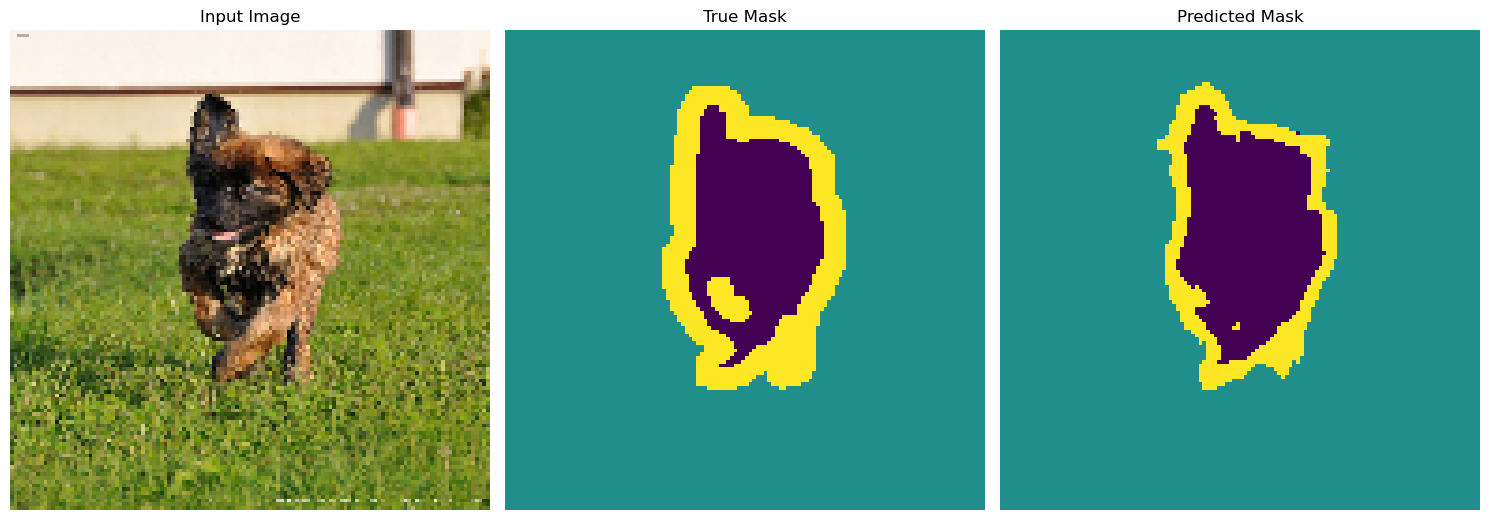

2/2 [==============================] - 4s 2s/step


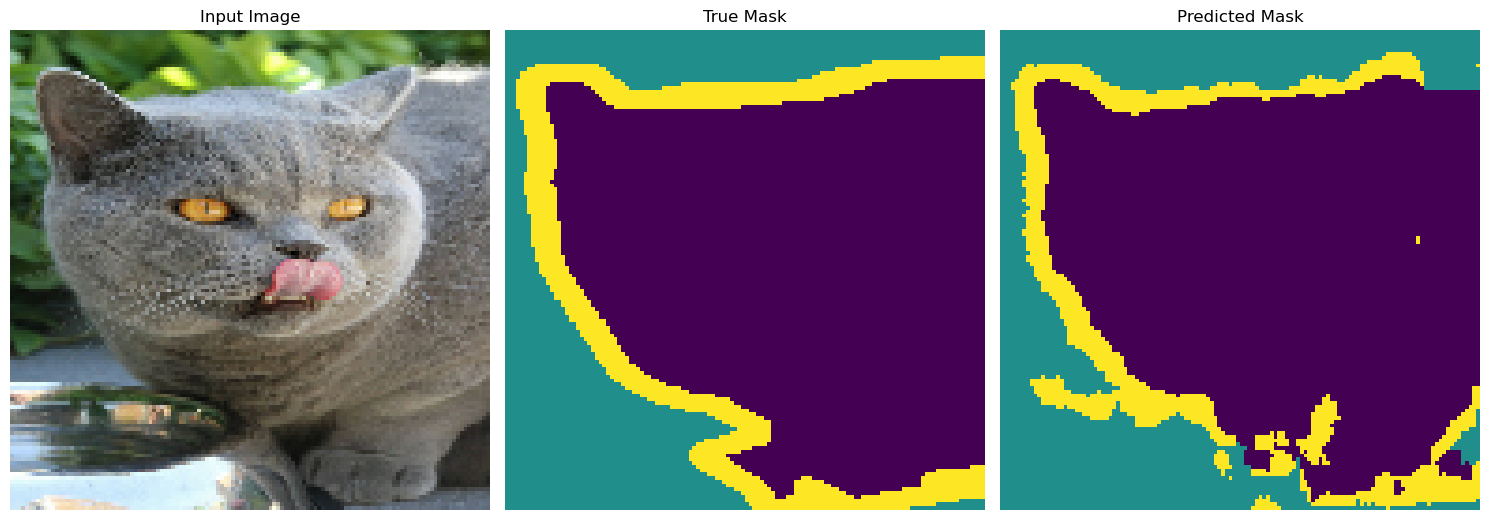

2/2 [==============================] - 4s 2s/step


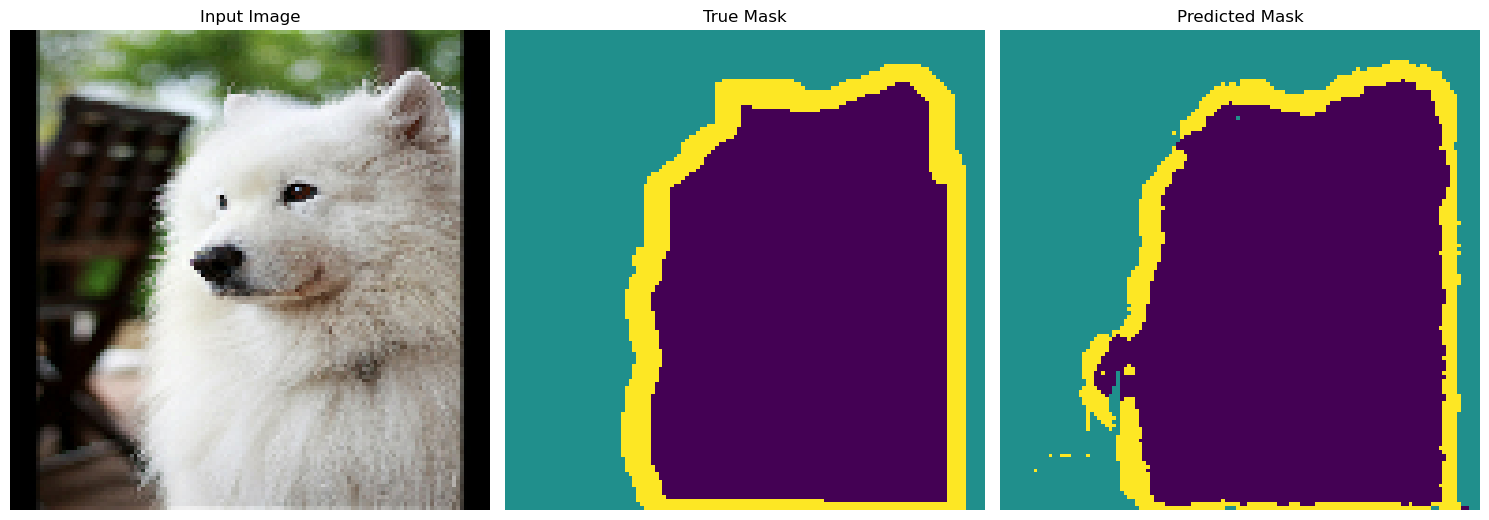

In [25]:
show_predictions(test_batches, 3)

## Imbalanced classes and class weights

Semantic segementation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem bu weighing the loss function to account for this. It's a simple and elegant way to deal with this problem.

To avoid ambiguity, Model.fit does not support the class_weight argument for targets with 3+ dimensions.

In [27]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Expected ValueError: `class_weight` not supported for 3+ dimensional targets.


So, in this case you need to implement the weighting yourself. You will do this using sample weights: In addition to (data, label) pairs, Model.fit also accespts (data, label, sample_weights) triples.

Keras Model.fit propagates the sample_weight to the losses and metrics, which also accept a sample_weight argument. The sample weight is multiplied by the sample's value before the reduction step. E.g:

In [28]:
label = [0, 0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                    reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

array([ 3.0485873, 30.485874 ], dtype=float32)

So, to make sample weights for this tutorial, you need a function that takes a (data, label) pair and returns a (data, label, sample_weight) triple where the sample_weight is a 1-channel image containing the class weight for each pixel.

The simplest possible implementation is to use the label as an index into a class_weight list:

In [31]:
def add_sample_weights(image, label):
    # The weights for each image, with the contraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([2.0, 2.0, 1.0])
    class_weights = class_weights/tf.reduce_sum(class_weights)
    
    # Create an image of 'sample_weights' by using the label at each pixes as an
    # index into the 'class_weights' .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    
    return image, label, sample_weights

The resulting dataset elements contain 3 images each:

In [32]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Now, you can train a model on this weighted dataset:

In [33]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [34]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 [==============================] - 97s 8s/step - loss: 0.2941 - accuracy: 0.6190
